In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import cv2
import os
import numpy as np
from pathlib import Path
import shutil
import zipfile

import torch
import torch.nn as nn
from torchvision.models import vgg19
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms, datasets
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import MSELoss
from torchvision.utils import make_grid
import timm

from PIL import Image
from pycocotools.coco import COCO
import requests # just use zip files instead

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#COCO Dataset for context
#Start with zip file in CV2 folder on drive. Unzips all files to CV2/coco

# zip_path = '/content/drive/MyDrive/CV2/coco_test2017.zip'
# extract_to = '/content/drive/MyDrive/CV2/coco'
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     # Extract all the contents into the directory
#     zip_ref.extractall(extract_to)
# print("Files unzipped successfully!")

In [ ]:
# Counting the files in CV2/coco, should be 81k
# file_count = 0
# for root, dirs, files in os.walk(extract_to):
#     file_count += len(files)

# print(f"Total files unzipped: {file_count}")

Total files unzipped: 81341


In [ ]:
# Wikiart style dataset
# Setup folders for wikiart extract
# os.chdir('/content/drive/MyDrive/CV2')
# os.makedirs('/content/style', exist_ok=True) # colab local directory
# os.makedirs('/content/drive/MyDrive/CV2/style', exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Unzip style files from gdrive into style folder in CV2
# zip_files = ['romanticism.zip', 'rococo.zip', 'neoclassicism.zip', 'impressionism.zip', 'abstract_expressionism.zip']
# for zip_file in zip_files:
#     with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#         # zip_ref.extractall('/content/style')
#         zip_ref.extractall('/content/drive/MyDrive/CV2/style')

In [ ]:
#Move all style files from artist folders to new dir called style2 in drive
# os.makedirs('/content/drive/MyDrive/CV2/style2', exist_ok=True)
# source_dir = '/content/drive/MyDrive/CV2/style'
# destination_dir = '/content/drive/MyDrive/CV2/style2'
# folder = ['abstract_expressionism', 'impressionism', 'neoclassicism', 'rococo', 'romanticism']

# for genre in folder:
#     genre_path = os.path.join(source_dir, genre)
#     for root, dirs, files in os.walk(genre_path):
#         for file in files:
#             if file.lower().endswith('.jpg'):
#                 source_file_path = os.path.join(root, file)
#                 destination_file_path = os.path.join(genre_path, file)
#                 if root != genre_path:
#                     shutil.move(source_file_path, destination_file_path)

# for genre in folder:
#     genre_path = os.path.join(source_dir, genre)
#     for file in os.listdir(genre_path):
#         if file.lower().endswith('.jpg'):
#             source_file_path = os.path.join(genre_path, file)
#             destination_file_path = os.path.join(destination_dir, file)
#             if os.path.exists(destination_file_path):
#                 base, extension = os.path.splitext(destination_file_path)
#                 i = 1
#                 new_destination_file_path = f"{base}_{i}{extension}"
#                 while os.path.exists(new_destination_file_path):
#                     i += 1
#                     new_destination_file_path = f"{base}_{i}{extension}"
#                 destination_file_path = new_destination_file_path
#             shutil.move(source_file_path, destination_file_path)

In [ ]:
# crop image
def preprocess_image(image):
    height, width = image.shape[:2]
    new_size = min(height, width)
    top = (height - new_size) // 2
    left = (width - new_size) // 2
    right = left + new_size
    bottom = top + new_size
    image_cropped = image[top:bottom, left:right]
    resized_image = cv2.resize(image_cropped, (256, 256))
    return resized_image

In [ ]:
# #Setup folders to process images from style2 to styleprocessed
# !rm -rf /content/drive/MyDrive/CV2/styleprocessed
# os.makedirs('/content/drive/MyDrive/CV2/styleprocessed', exist_ok=True)
# data_path = Path('/content/drive/MyDrive/CV2/style2')
# style_processed = Path('/content/drive/MyDrive/CV2/styleprocessed')
# style_processed.mkdir(parents=True, exist_ok=True)

In [ ]:
# # WikiArt
# # Process 'count' number of images and place into styleprocessedfolder

# from google.colab import drive
# drive.mount('/content/drive')


# count = 0
# for filename in os.listdir(data_path):
#     if filename.lower().endswith('.jpg'):
#         image_path = data_path / filename
#         image = cv2.imread(str(image_path))
#         if image is not None:
#             processed_image = preprocess_image(image)
#             processed_path = style_processed / filename
#             cv2.imwrite(str(processed_path), processed_image)
#             count += 1
#     if count == 10000:
#         break
# print(f"Files: {len(os.listdir('/content/drive/MyDrive/CV2/styleprocessed'))}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files: 10000


In [ ]:
# #Setup folders to process from coco to coco_style_processed
# !rm -rf /content/drive/MyDrive/CV2/coco_styleprocessed
# os.makedirs('/content/drive/MyDrive/CV2/coco_styleprocessed', exist_ok=True)
# data_path = Path('/content/drive/MyDrive/CV2/coco/test2017')
# coco_style_processed = Path('/content/drive/MyDrive/CV2/coco_styleprocessed')
# coco_style_processed.mkdir(parents=True, exist_ok=True)

In [ ]:
# # COCO
# # Process 'count' number of images and place into coco_styleprocessedfolder

# from google.colab import drive
# drive.mount('/content/drive')

# count = 0
# for filename in os.listdir(data_path):
#     if filename.lower().endswith('.jpg'):
#         image_path = data_path / filename
#         image = cv2.imread(str(image_path))
#         if image is not None:
#             processed_image = preprocess_image(image) #keep
#             processed_path = coco_style_processed / filename #keep
#             cv2.imwrite(str(processed_path), processed_image)
#             count += 1
#     if count == 10000:
#         break
# print(f"Files: {len(os.listdir('/content/drive/MyDrive/CV2/coco_styleprocessed'))}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print(f"Files: {len(os.listdir('/content/drive/MyDrive/CV2/styleprocessed'))}")
print(f"Files: {len(os.listdir('/content/drive/MyDrive/CV2/coco_styleprocessed'))}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files: 10000
Files: 10000


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.image_files[index])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
# Create Dataloaders
style_processed = Path('/content/drive/MyDrive/CV2/styleprocessed')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = ImageDataset(style_processed, transform=transform)
train_dataset, test_dataset = random_split(dataset, [9900, 100])
train_style_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_style_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

#####
coco_style_processed = Path('/content/drive/MyDrive/CV2/coco_styleprocessed')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = ImageDataset(coco_style_processed, transform=transform)
train_dataset, test_dataset = random_split(dataset, [9900, 100])
train_coco_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_coco_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Example of sinusoidal positional encoding implementation in PyTorch

# import math
# import torch

# def sinusoidal_positional_encoding(n_positions, dim_model):
#     position_enc = torch.zeros((n_positions, dim_model))
#     for pos in range(n_positions):
#         for i in range(0, dim_model, 2):
#             position_enc[pos, i] = math.sin(pos / (10000 ** ((2 * i)/dim_model)))
#             if i + 1 < dim_model:
#                 position_enc[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/dim_model)))
#     return position_enc

In [ ]:
class TransferNN(nn.Module):
    def __init__(self, encoder_name='vit_base_patch16_224', img_size=256):
        super(TransferNN, self).__init__()
        self.encoder = timm.create_model(encoder_name, pretrained=True, img_size=img_size, num_classes=0)
        self.in_features = self.encoder.embed_dim
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.in_features, 512, kernel_size=4, stride=1, padding=0),  # 4x4
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),  # 256x256
            nn.Tanh()
        )

    def forward(self, content, style):
        content_features = self.encoder(content)
        style_features = self.encoder(style)
        # print("content, style:", content_features.shape, style_features.shape)
        combined_features = content_features + style_features
        combined_features = combined_features.unsqueeze(-1).unsqueeze(-1)
        # print("shape after unsqueeze:", combined_features.shape)
        styled_image = self.decoder(combined_features)
        # print("Output styled image shape:", styled_image.shape)
        return styled_image


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from datetime import datetime

# datetime object containing current date and time
# now = datetime.now()

# print("now =", now)

model = TransferNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = MSELoss()

vgg = vgg19(pretrained=True).features.to(device)
vgg.eval()
for param in vgg.parameters():
    param.requires_grad = False

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a, b, c * d)
    G = torch.bmm(features, features.transpose(1, 2))
    return G.div(b * c * d)

# Training settings
# num_epochs = 15
num_epochs = 1
print_interval = 1
total_losses = []
style_losses = []
content_losses = []

# Training loop
cur_epoch = 0
for epoch in range(num_epochs):
    cur_epoch +=1
    print("Epoch: ", cur_epoch)
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    print("START date and time =", dt_string)


    model.train()
    total_loss = 0.0
    total_style_loss = 0.0
    total_content_loss = 0.0

    for content_images, style_images in zip(train_coco_dataloader, train_style_dataloader):
        content_images = content_images.to(device)
        style_images = style_images.to(device)
        optimizer.zero_grad()
        styled_images = model(content_images, style_images)
        # print("out: ", styled_images.shape)
        # print("content: ", content_images.shape)
        content_features = vgg(content_images).detach()
        styled_features = vgg(styled_images)

        content_loss = criterion(styled_features, content_features)
        style_features = vgg(style_images).detach()
        gram_style = gram_matrix(style_features)
        gram_styled = gram_matrix(styled_features)
        style_loss = criterion(gram_styled, gram_style)
        total = 10 * content_loss + 10000000 * style_loss
        temp = total
        total.backward()
        optimizer.step()

        total_loss += temp.item()
        total_style_loss += 10000000 * style_loss.item()
        total_content_loss += 10 * content_loss.item()

    # Record the average loss for this epoch
    # print(total_loss)
    # print(total_style_loss)
    # print(total_content_loss)
    length = len(train_coco_dataloader)
    total_losses.append(total_loss / length)
    style_losses.append(total_style_loss / length)
    content_losses.append(total_content_loss / length)
    if (epoch + 1) % print_interval == 0:
        print(f'Epoch {epoch+1}: Average Loss: {total_loss / len(train_coco_dataloader.dataset):.4f}')

    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    print("END date and time =", dt_string)

model_save_path = '/content/drive/MyDrive/CV2/transfer_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')


now = 2024-04-24 14:29:36.077800


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch:  1
START date and time = 24/04/2024 14:29:36
Epoch 1: Average Loss: 2.1152
END date and time = 24/04/2024 14:29:36
Model saved to /content/drive/MyDrive/CV2/transfer_model.pth


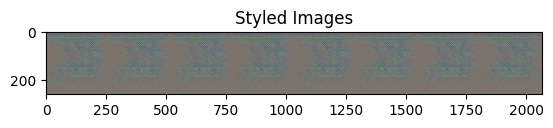

In [15]:
# load model if runtime disconnected
model = TransferNN()
model_save_path = '/content/drive/MyDrive/CV2/transfer_model.pth'
model.load_state_dict(torch.load(model_save_path))
model = model.to('cuda')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def imshow(inp, title=None):
    """Imshow for Tensor."""
    if inp.is_cuda:
        inp = inp.cpu()  # Ensure tensor is on CPU
    inp = inp.detach().numpy().transpose((1, 2, 0))  # Convert to numpy array and transpose
    mean = np.array([0.485, 0.456, 0.406])  # Normalize mean
    std = np.array([0.229, 0.224, 0.225])   # Normalize std deviation
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


model.eval()  # Set the model to evaluation mode
# Assuming you want to generate images using test dataloaders
for content_images, style_images in zip(test_coco_dataloader, test_style_dataloader):
    content_images = content_images.to(device)
    style_images = style_images.to(device)

    with torch.no_grad():  # Disable gradient computation
        styled_images = model(content_images, style_images)

    # Convert images to CPU and display
    grid = make_grid(styled_images)
    imshow(grid, title="Styled Images")

    break  # Remove break to process more batches or generate more images


[2.5459413525797143]
[14.368561287688902]


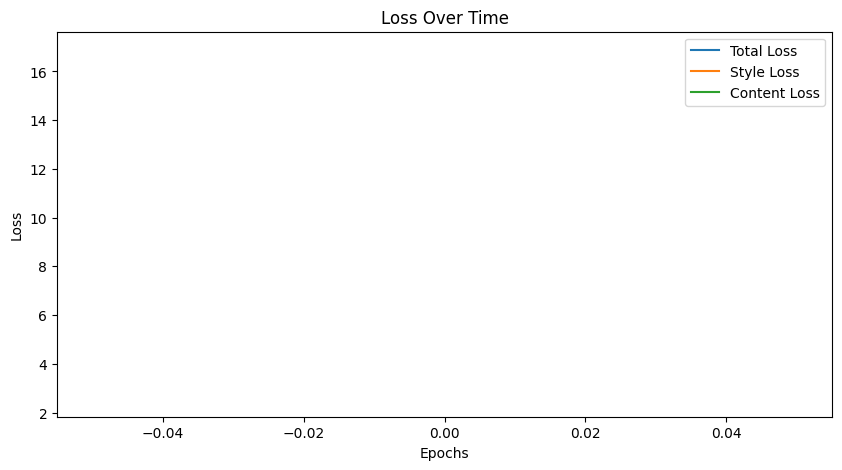

In [12]:
print(style_losses)
print(content_losses)
plt.figure(figsize=(10, 5))
plt.plot(total_losses, label='Total Loss')
plt.plot(style_losses, label='Style Loss')
plt.plot(content_losses, label='Content Loss')
plt.title('Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

To Do:
- upload coco zip files - DONE
- GCP Cloud
- process style + content images from wiki art and coco, put into data loader for train + test - DONE FOR WIKIART, COCO code done - Danny needs to run COCO code
- write neural architecture (assume we use the same model and only modify training loss)
  - use encoder + decoder architecture with pytorch's built in vision transformer
  - maybe use different postional encoding than authors suggest (or write simple code for sinuisoidal encoding) - ADDED SAMPLE CODE FOR SINUSOIDAL
- training loop - 2 diff models --> output image for both loops - ADDED SAMPLE
  - 1) train on content loss & style loss. we'll use mean squared error and graham matrix
  - 2) add perceptual loss (passing some of the inbetween representations into a pretrained model and obtaining loss that way)
  - 1 graphic for loss over time and image
- test: - ADDED SAMPLE PLOTTING CODE
  - output 10 images from models

- write up
  - Intro - DONE WITH DRAFT
  - Related Work - DONE WITH DRAFT
  - Methodology - DONE WITH DRAFT
  - Results
  - Discussion
  - Conclusion
  - References
